In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import emcee
import os

import sys
sys.path.insert(0, '../')

In [2]:
k2_time, k2_flux, k2_err = np.loadtxt('../libra/data/trappist1/trappist_rotation.txt', unpack=True)
k2_flux /= np.percentile(k2_flux, 95)
k2_time_original, k2_flux_original = k2_time.copy(), k2_flux.copy()

In [3]:
# slice in time
condition = (k2_time > 2457773) & (k2_time < 2457779)
k2_time, k2_flux, k2_err= k2_time[condition], k2_flux[condition], k2_err[condition]

<Container object of 3 artists>

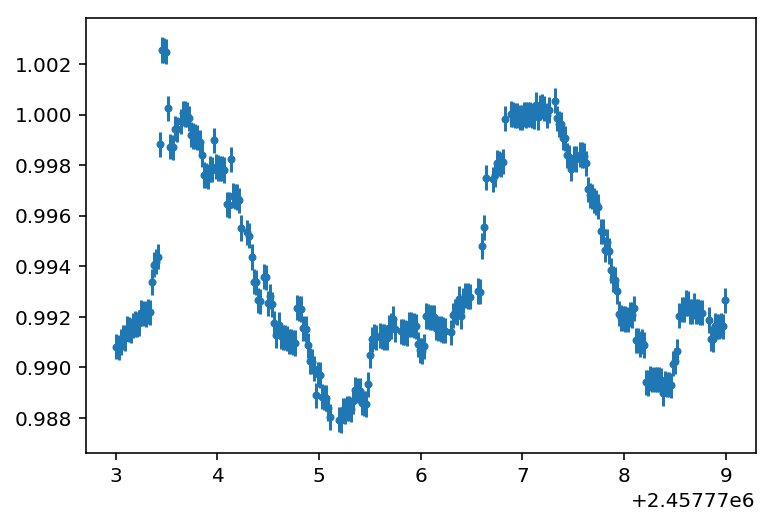

In [4]:
plt.errorbar(k2_time, k2_flux, k2_err, fmt='.')

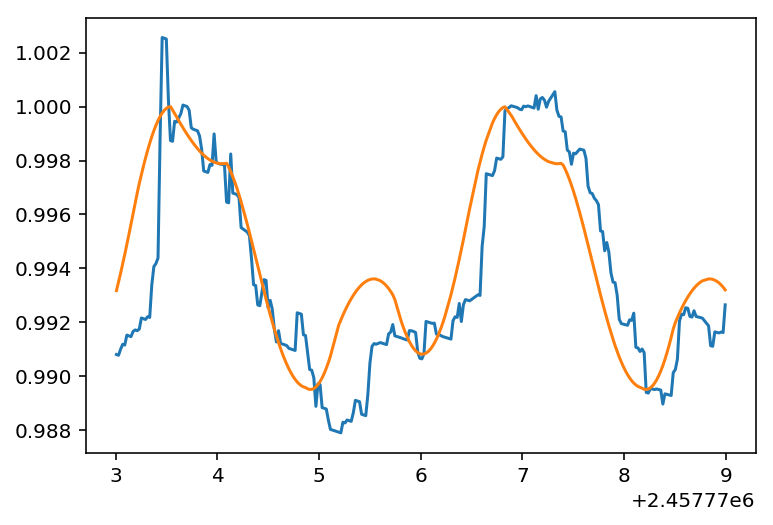

In [5]:
from libra import Spot, Star


spots = [Spot.from_latlon(0, 100, 0.18, contrast=0.7), 
         Spot.from_latlon(0, 220, 0.17, contrast=0.7), 
         Spot.from_latlon(0, 5, 0.1, contrast=0.7)]

star = Star(spots=spots, rotation_period=3.3*u.day)
model_flux =  star.flux(k2_time)
model_flux /= np.max(model_flux)

plt.plot(k2_time, k2_flux)
plt.plot(k2_time, model_flux)


In [6]:
def model(p, time):
    lat0, lon0, rad0, lat1, lon1, rad1, lat2, lon2, rad2, contrast, kep_offset = p
    
    spots = [Spot.from_latlon(lat0, lon0, rad0, contrast=contrast), 
             Spot.from_latlon(lat1, lon1, rad1, contrast=contrast), 
             Spot.from_latlon(lat2, lon2, rad2, contrast=contrast)]

    star = Star(spots=spots, rotation_period=3.3*u.day)
    model_flux = star.flux(time).value
    model_flux /= np.max(model_flux)
    model_flux += kep_offset

    return model_flux

def chi2(p, time):
    return np.sum((model(p, time) - k2_flux)**2 / k2_err**2)

from scipy.optimize import fmin_l_bfgs_b, fmin_powell


initp = np.array([  0.00000000e+00,   145,   1.45795979e-01,
                    0.00000000e+00,   225,   1.43055223e-01,
                    0.00000000e+00,   70,   1.38107241e-01, 
                    0.7, 0])

bounds = [[-90, 90], [0, 360], [0, 1],
          [-90, 90], [0, 360], [0, 1],
          [-90, 90], [0, 360], [0, 1]]

#result0 = fmin_l_bfgs_b(chi2, initp, args=(k2_time, ), approx_grad=True, bounds=bounds)[0]
#result1 = fmin_powell(chi2, initp, args=(k2_time, ))

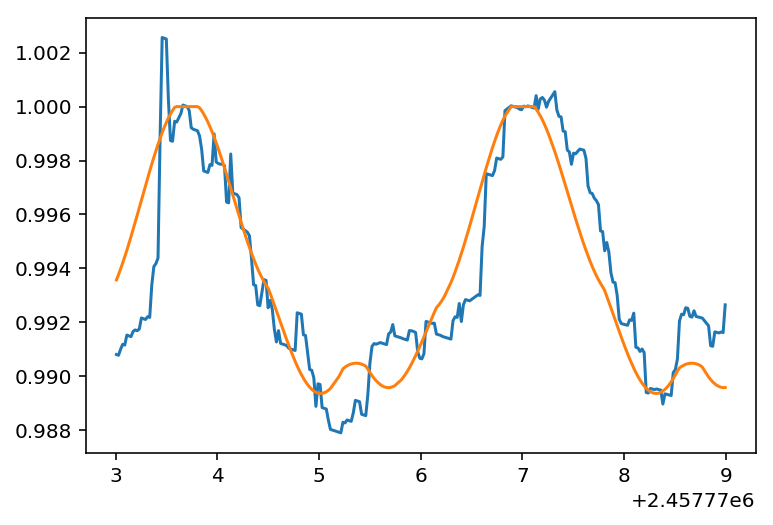

In [7]:
#%matplotlib notebook
plt.plot(k2_time, k2_flux)
plt.plot(k2_time, model(initp, k2_time))
#plt.plot(k2_time, model(result1, k2_time))

In [8]:
def lnprior(p):
    lat0, lon0, rad0, lat1, lon1, rad1, lat2, lon2, rad2, contrast, kep_offset = p
    lats = np.array([lat0, lat1, lat2])
    lons = np.array([lon0, lon1, lon2])
    rads = np.array([rad0, rad1, rad2])
    
    if np.any(lats < -90) or np.any(lats > 90):
        return -np.inf
    if np.any(lons < 0) or np.any(lons > 360):
        return -np.inf
    if np.any(rads < 0) or np.any(rads > 1):
        return -np.inf
    
    if not (110 < lon0 < 170 and 200 < lon1 < 250 and 40 < lon2 < 80):
        return -np.inf
    
    if not (0 < contrast < 1):
        return -np.inf
    return 0

def lnprob(p, time):
    lp = lnprior(p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + -0.5*chi2(p, time)

ndim, nwalkers = 11, 50
pos = [initp + np.concatenate([1e-1*np.random.randn(ndim-1), [np.random.rand()]]) for i in range(nwalkers)]

In [48]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(k2_time, ), 
                                threads=8)
sampler.run_mcmc(pos, 1000);

/Users/bmmorris/anaconda/lib/python3.5/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/bmmorris/anaconda/lib/python3.5/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


In [49]:
n_burnin = 500
samples = sampler.chain[:, n_burnin:, :].reshape((-1, ndim))

In [50]:
labels = ['lat', 'lon', 'rad', 'lat', 'lon', 'rad', 'lat', 'lon', 'rad', 'contrast', 'kep_offset']

Text(0.5,0,'contrasts')

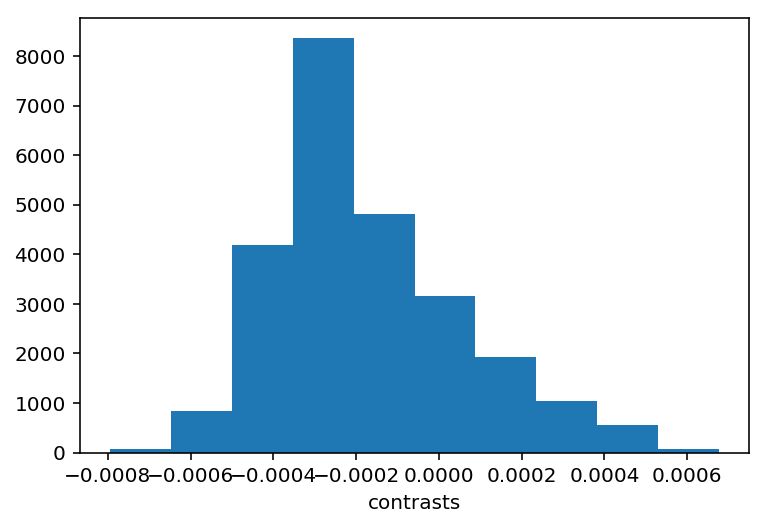

In [51]:
plt.hist(samples[:, -1])
plt.xlabel('contrasts')

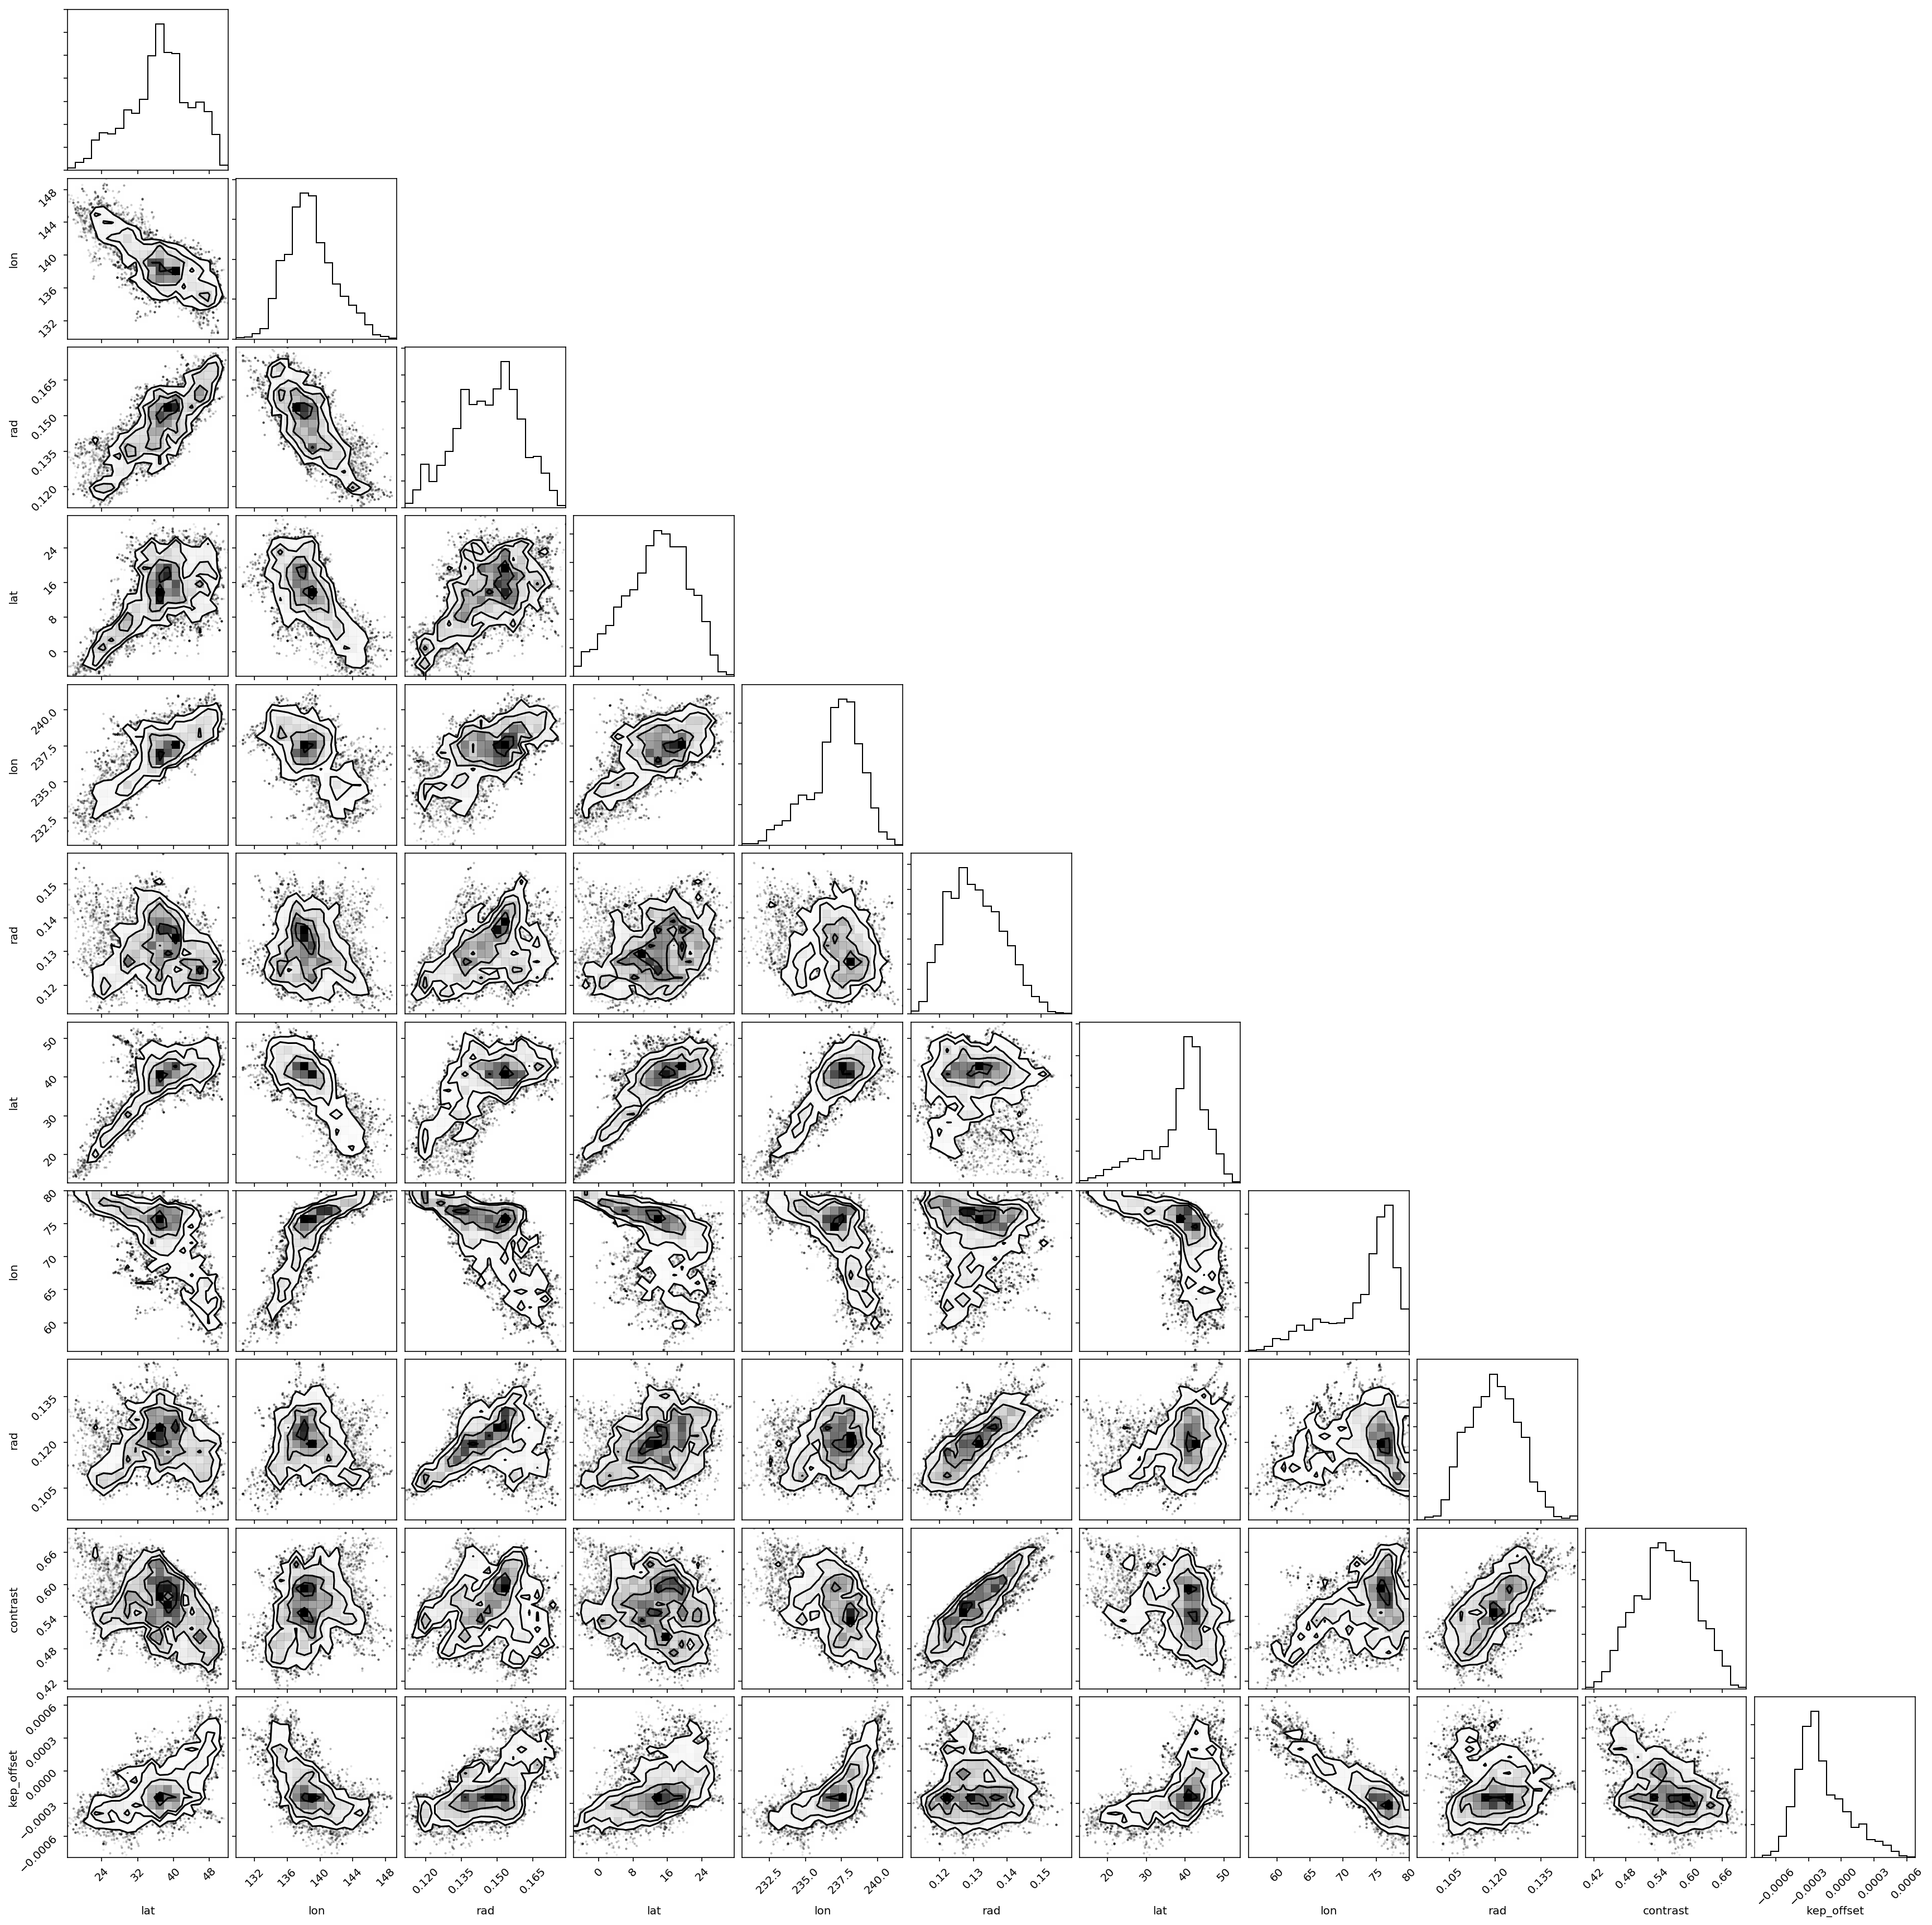

In [52]:
from corner import corner

corner(samples, labels=labels)

plt.savefig('corner_darkspot.png', bbox_inches='tight', dpi=250)
plt.show()

Text(0.5,0,'radii')

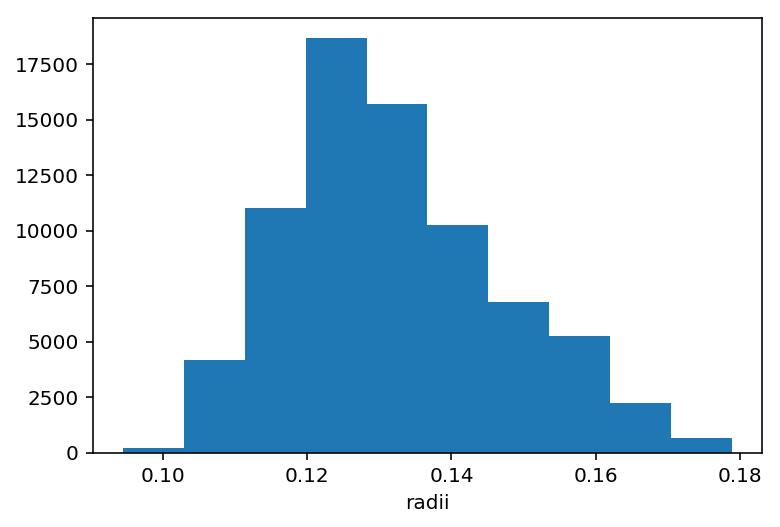

In [53]:
plt.hist(samples[:, 2::3].ravel())
plt.xlabel('radii')

In [54]:
np.savetxt("trappist1_spotmodel_posteriors.txt", samples)

In [9]:
samples = np.loadtxt("trappist1_spotmodel_posteriors.txt")

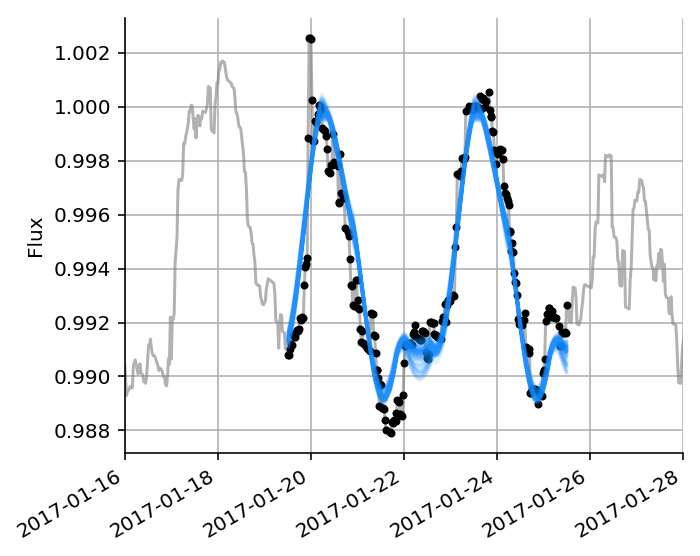

In [10]:
from astropy.time import Time

plt.figure(figsize=(5, 4))
plt.plot_date(Time(k2_time_original, format='jd').plot_date, 
              k2_flux_original, ms=0, ls='-', alpha=0.6, color='gray')

plt.plot_date(Time(k2_time, format='jd').plot_date, k2_flux, '.k', lw=2)

for i in np.random.randint(0, samples.shape[0], 200):
    plt.plot_date(Time(k2_time, format='jd').plot_date, 
                  model(samples[i, :], k2_time), ms=0, ls='-', alpha=0.05, color='DodgerBlue')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid()
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
plt.ylabel('Flux')
plt.xlim([Time('2017-01-16').plot_date, Time('2017-01-28').plot_date])
plt.savefig('model_darkspots.pdf', bbox_inches='tight')
plt.show()

In [11]:
kepler_contrast, spitzer_contrast = np.loadtxt('kepler_to_spitzer_contrast.txt', unpack=True)

def kepler_to_spitzer_contrast_interp(contrast):
    return np.interp(contrast, kepler_contrast, spitzer_contrast)

def model(p, kepler_time):
    lat0, lon0, rad0, lat1, lon1, rad1, lat2, lon2, rad2, kepler_contrast, kep_offset = p
    
    # Kepler
    spots = [Spot.from_latlon(lat0, lon0, rad0, contrast=kepler_contrast), 
             Spot.from_latlon(lat1, lon1, rad1, contrast=kepler_contrast), 
             Spot.from_latlon(lat2, lon2, rad2, contrast=kepler_contrast)]

    kepler_star = Star(spots=spots, rotation_period=3.3*u.day)
    kepler_model_flux = kepler_star.flux(kepler_time)
    norm_factor = np.max(kepler_model_flux)
    kepler_model_flux /= norm_factor
    kepler_model_flux += kep_offset
    
    # Spitzer
    spitzer_contrast = kepler_to_spitzer_contrast_interp(kepler_contrast)

    # Kepler
    spots = [Spot.from_latlon(lat0, lon0, rad0, contrast=spitzer_contrast), 
             Spot.from_latlon(lat1, lon1, rad1, contrast=spitzer_contrast), 
             Spot.from_latlon(lat2, lon2, rad2, contrast=spitzer_contrast)]

    spitzer_star = Star(spots=spots, rotation_period=3.3*u.day)
    spitzer_model_flux = spitzer_star.flux(kepler_time)
    norm_factor = np.max(spitzer_model_flux)
    spitzer_model_flux /= norm_factor
    spitzer_model_flux += kep_offset
    
    return kepler_model_flux, spitzer_model_flux

In [12]:
#best_params = sampler.flatchain[np.argmax(sampler.flatlnprobability), :]

best_model_k2, best_model_sp = model(np.median(samples, axis=0), k2_time)

In [13]:
spitzer_time, spitzer_flux, spitzer_err, _ = np.loadtxt('../libra/data/T1_Spitzer.txt', 
                                              unpack=True, delimiter=',')
spitzer_time += k2_time.min() - spitzer_time[0]
spitzer_flux += 1

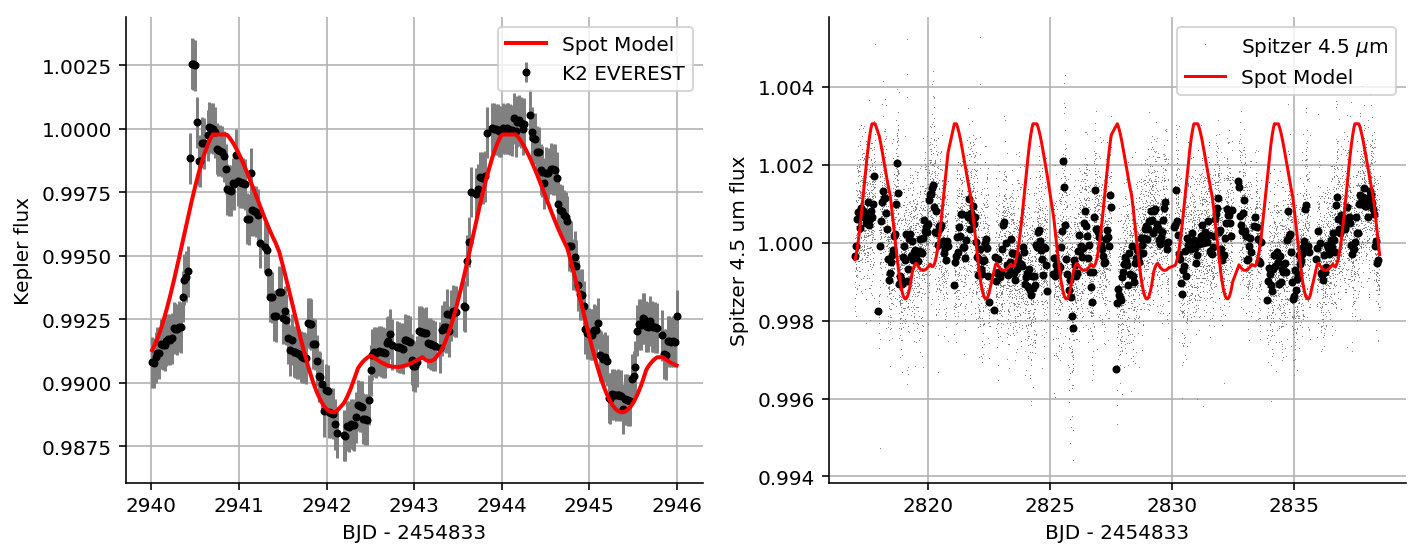

In [17]:
extended_model_k2, extended_model_sp = model(np.median(samples, axis=0), spitzer_time)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

bjd_offset = 2454833
actual_spitzer_t0 = 7650 + 2450000

ax[0].errorbar(k2_time - bjd_offset, k2_flux, 2*k2_err, fmt='.', color='k', ecolor='gray', label='K2 EVEREST')
ax[0].plot(k2_time - bjd_offset, best_model_k2, color='r', zorder=10, lw=2, label='Spot Model')
ax[0].set(xlabel='BJD - 2454833', ylabel='Kepler flux')
ax[0].legend()

# ax[1].errorbar(spitzer_time, spitzer_flux, spitzer_err, 
#                label='Spitzer 4.5 $\mu$m', fmt='.', color='#333333', ecolor='silver', ms=0.5)
ax[1].plot(spitzer_time - k2_time.min() + actual_spitzer_t0 - bjd_offset, spitzer_flux, ',', label='Spitzer 4.5 $\mu$m', color='gray', ms=1)

bins = np.arange(spitzer_time.min(), spitzer_time.max(), 1/24)
from scipy.stats import binned_statistic
bs = binned_statistic(spitzer_time, spitzer_flux, bins=bins, statistic='mean')
ax[1].plot(bins[:-1] - k2_time.min() + actual_spitzer_t0 - bjd_offset, bs.statistic, 'k.')

ax[1].plot(spitzer_time - k2_time.min() + actual_spitzer_t0 - bjd_offset, extended_model_sp/np.median(extended_model_sp), 
           label='Spot Model', color='r', zorder=10)
ax[1].legend(loc='upper right')
ax[1].set(xlabel='BJD - 2454833', ylabel='Spitzer 4.5 um flux')

for axis in ax: 
    axis.grid()
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)

fig.tight_layout()
fig.savefig('best_dark_spot_model.png', bbox_inches='tight', dpi=250)
fig.savefig('best_dark_spot_model.pdf', bbox_inches='tight')

In [20]:
k2_time.min() - (7668.653894 + 2450000)

104.35518671711907